<h1><font size=12>
Weather Derivatites </h1>
<h1> Hidden Markov Chain - EM<br></h1>

Developed by [Jesus Solano](mailto:ja.solano588@uniandes.edu.co) <br>  
1 September 2018 


In [7]:
# Import needed libraries. 
import numpy as np
import pandas as pd
import random as rand
import matplotlib.pyplot as plt
from scipy.stats import norm
from scipy.stats import gamma
import time

## Download Rainfall Data - El dorado Airport

In [8]:
# Download Data

# Configure path to read txts.

path = '../datasets/'

# Download the update dataset.

import os

if not os.path.exists(path+'precipitationAllTime.csv'):

  ! wget https://github.com/jesugome/WeatherDerivates/raw/master/datasets/precipitationAllTime.csv -P path

  ! wget https://github.com/jesugome/WeatherDerivates/raw/master/datasets/precipitationRemovingAverageAllTime.csv -P path


precipitationAllTime = pd.read_csv(path+'precipitationAllTime.csv',header=None, names = ['Date','Prep'])

precipitationReAllTime = pd.read_csv(path+'precipitationRemovingAverageAllTime.csv')

precipitationAllTime['Date'] = pd.to_datetime(precipitationAllTime['Date'])
precipitationAllTime = precipitationAllTime.set_index('Date')


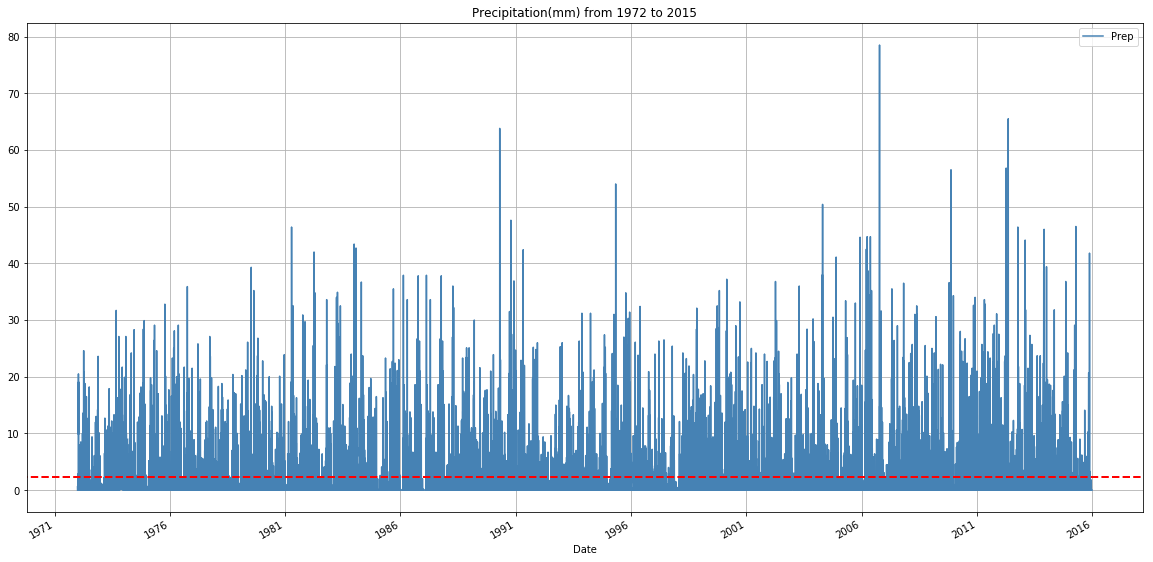

In [9]:
# Plot precipitation over a set of years.

startYear = 1972
endYear = 2015

meanAllTime = precipitationAllTime.mean()
ax = precipitationAllTime.plot(title='Precipitation(mm) from '+ str(startYear) +' to '+str(endYear),figsize=(20,10),grid=True,color='steelblue')
ax.axhline(y=meanAllTime[0], xmin=-1, xmax=1, color='r', linestyle='--', lw=2)

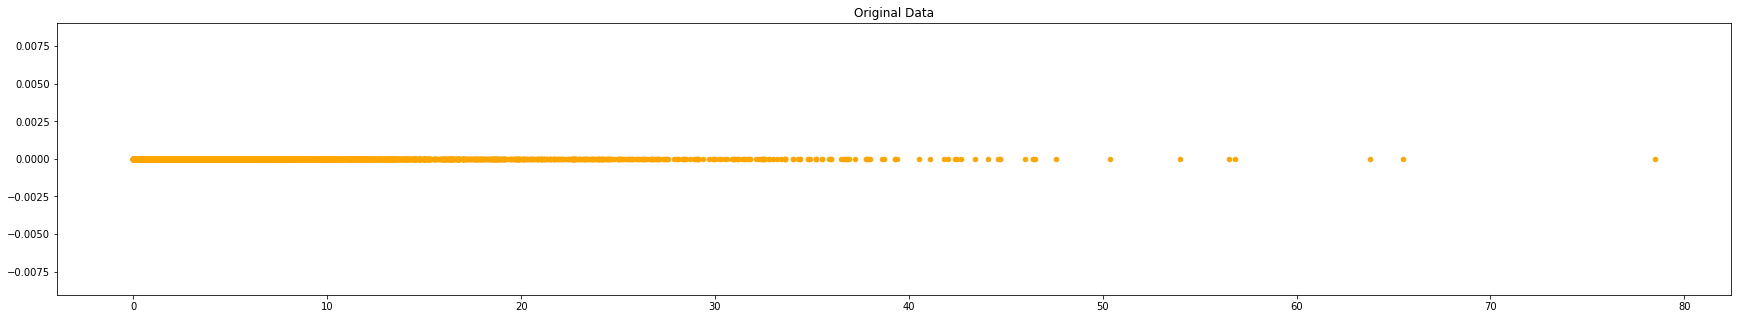

In [10]:
# Data scatter plot. 

fig = plt.figure(figsize=(30, 5))
plt.scatter(precipitationAllTime['Prep'],np.zeros(precipitationAllTime.shape[0]), 20 ,c='orange')
plt.title('Original Data')
plt.show()

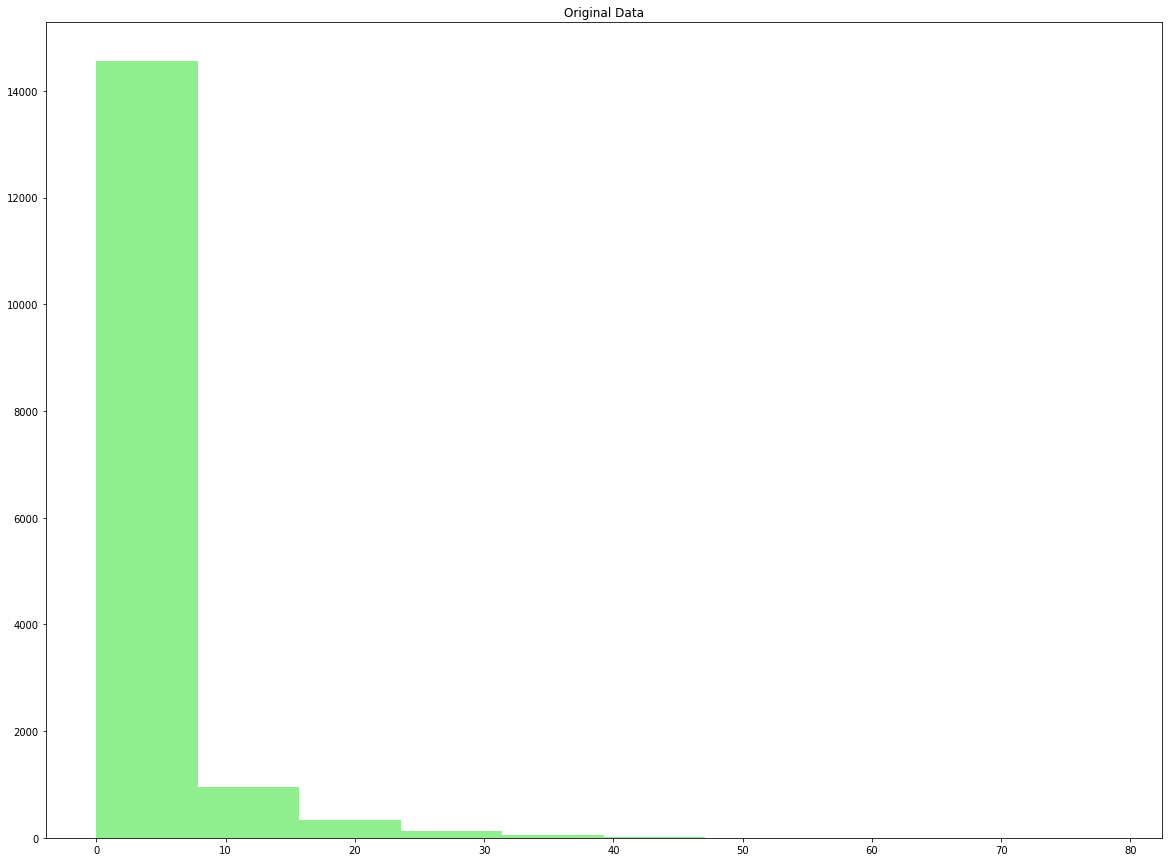

In [11]:
# Data scatter plot. 

fig = plt.figure(figsize=(20, 15))
plt.hist(precipitationAllTime['Prep'],color='lightgreen')
plt.title('Original Data')
plt.show()

# Expectation - Maximization Method 

### EM Functions

In [12]:
# Expectation: assign every data point to its most likely state.

def expectation(data, parameters, numStates, probType):
    
    # Creates an array to store responsabilites for each state.
    statesProb = [None]*numStates
    dataframe = data.copy()
    
    # Loop over historical precipitation. 
    for i in range(dataframe.shape[0]):
        # Get precipitation ammount. 
        precipitation = dataframe['Prep'][i]
        
        for cl in range(numStates):
            
            statesProb[cl] = probabilities(precipitation, parameters['param1'][cl],parameters['param2'][cl],parameters['percentage'][cl], probType,parameters['probZero'][cl])
        
        maxCl = statesProb.index(max(statesProb))
        
        if precipitation > 0 :
            dataframe['state'][i] = maxCl
        else:
            dataframe['state'][i] = 0
        
    return dataframe

# Maximization : Updates estimators. 
def maximization(dataframe, parameters, numStates, probType):
    
    dataAssignedToState = [None]* numStates
    percentAssignedToState = [None]* numStates
    
    for cl in range(numStates):
        
        # Find data assigned to state.
        dataAssignedToState[cl] = dataframe[dataframe['state']==cl]
        percentAssignedToState[cl] = len(dataAssignedToState[cl])/ float(len(dataframe))
        
        # Update parameters. 
        parameters['percentage'][cl] = percentAssignedToState[cl]
        
        # Update zeros proportion in each state.
        probZeroVec = probZeroForEachState(numStates,dataframe)
        parameters['probZero'][cl] = probZeroVec[cl]
        
        
        if probType == 'gamma':
            '''
            Using gamma distribution the meaning of fuction parameters are:
            param1: a
            param2: scale
            percentage : state sample percentage
            '''
            parameters['param2'][cl] = dataAssignedToState[cl]['Prep'].var() / dataAssignedToState[cl]['Prep'].mean() 
            parameters['param1'][cl] = (dataAssignedToState[cl]['Prep'].mean()*dataAssignedToState[cl]['Prep'].mean()) / dataAssignedToState[cl]['Prep'].var() 
        # Case for normal distribution.
        elif probType == 'normal':
            '''
            Using gamma distribution the meaning of fuction parameters are:
            param1: mu
            param2: std
            percentage : state sample percentage
            '''
            parameters['param1'][cl] = dataAssignedToState[cl]['Prep'].mean() 
            parameters['param2'][cl] = dataAssignedToState[cl]['Prep'].std() 
        
    return parameters

# Get the distance between parameters (used for determining if params have converged)
def distance(oldParams, newParams):
    dist = 0
    for param in ['param1', 'param2']:
        for i in range(len(oldParams)):
            dist += (oldParams[param][i] - newParams[param][i]) ** 2
    return dist ** 0.5
        

### EM Iterative Algorithm

In [13]:
# Generator of guess parameters.

def parameterGen(numStates):
    
    percentageList = rand.sample(range(1,10),numStates)

    sumPercentage = sum(percentageList)

    normPercentage = [e / sumPercentage for e in percentageList]

    parameter = {
        'param1': rand.sample(np.arange(1.0,10.0,0.2).tolist(),numStates),
        'param2': rand.sample(np.arange(1.0,10.0,0.2).tolist(),numStates),
        'percentage': normPercentage,
        'probZero' : [1.0]*numStates

    }
    
    return pd.DataFrame(parameter)



In [14]:
def probabilities(amount, param1, param2, percentage, probType,probZero):
    
    # Case for gamma distribution. 
    
    if probType == 'gamma':
        '''
        Using gamma distribution the meaning of fuction parameters are:
        param1: a
        param2: scale
        percentage : state sample percentage
        '''
        aV = param1
        scaleV = param2
        
        #prob = percentage*(probZero+(1-probZero)*gamma.pdf(amount, aV, scaleV))
        prob = percentage*(gamma.pdf(amount, aV, scaleV))
  
        return prob        
    
    # Case for normal distribution.
    elif probType == 'normal':
        '''
        Using gamma distribution the meaning of fuction parameters are:
        param1: mu
        param2: std
        percentage : state sample percentage
        '''
        mu = param1
        sig = param2
        
        #prob = percentage*(probZero+(1-probZero)*norm.pdf(amount, mu, sig))
        prob = percentage*(norm.pdf(amount, mu, sig))
  
        return prob
        
    else:
        print('Error: Enter a valid distribution.')
    

In [19]:
def probZeroForEachState(numStates,dataframe):
    # Create a list with proportion of zeros for each state. 
    probZero= [None]* numStates
    
    # Iterate over the states(clusters).
    for cl in range(numStates):
        
        # Find data assigned to state.
        dataAssignedToState = dataframe[dataframe['state']==cl]
        
        if float(len(dataAssignedToState))==0:
            zerosInData = 0
        
        else: 
            zerosInData = len(dataAssignedToState[dataAssignedToState['Prep']==0])/ float(len(dataAssignedToState))
        
        probZero[cl] = zerosInData
        
    return probZero   

In [20]:
def EMalgorithm(data, epsilon, param, numStates, probType):
    # Initialization.
    startTime = time.time()
    shift = float("inf")
    iterations = 0
    dataframe = data.copy()
    dataframe['state'] = np.random.choice(numStates,len(dataframe))    
    parameters = param.copy()
    
    parameters['probZero'] = probZeroForEachState(numStates,dataframe)
    
    # Loop until parameters converge.
    while shift > epsilon: 
        
        iterations += 1

        # Expectation step. 
        
        updatedStates = expectation(dataframe.copy(), parameters, numStates, probType)
               
        # Maximization step. 

        updatedParameters = maximization(updatedStates, parameters.copy(),numStates, probType)


        # Calculate parameters move. 
        shift = distance(parameters, updatedParameters)

        # Logging results.
        currentTime = time.time() - startTime 

        print('Iteration: {} -- Parameter Shift: {:.4f} -- CPU Time: {:.4f} \n'.format(iterations,shift,currentTime))

        print(updatedParameters)

        dataframe = updatedStates

        parameters = updatedParameters

        # Plot states.


        fig = plt.figure(figsize=(20,5))
        plt.scatter(dataframe['Prep'],np.zeros(dataframe.shape[0]), 20, c=dataframe['state'])
        plt.title('Iteration '+str(iterations))
        plt.show()

    
    return dataframe,parameters  
        

### A little example (Five Years) 

In [21]:
startYear = 2010
endYear = 2015

precipitationWindowTime=precipitationAllTime.loc[str(startYear)+'-01-01':str(endYear)+'-12-31']

Initial parameters are: 
    param1  param2  percentage  probZero
0     1.0     9.2        0.28       1.0
1     9.8     9.4        0.24       1.0
2     6.2     3.4        0.36       1.0
3     8.6     5.6        0.12       1.0 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration: 1 -- Parameter Shift: 852.2098 -- CPU Time: 99.0155 

       param1    param2  percentage  probZero
0    0.161190  4.009364    0.795434  0.547646
1    7.068910  3.283460    0.056621  0.000000
2    5.985293  1.073587    0.140183  0.000000
3  860.745763  0.016033    0.007763  0.000000


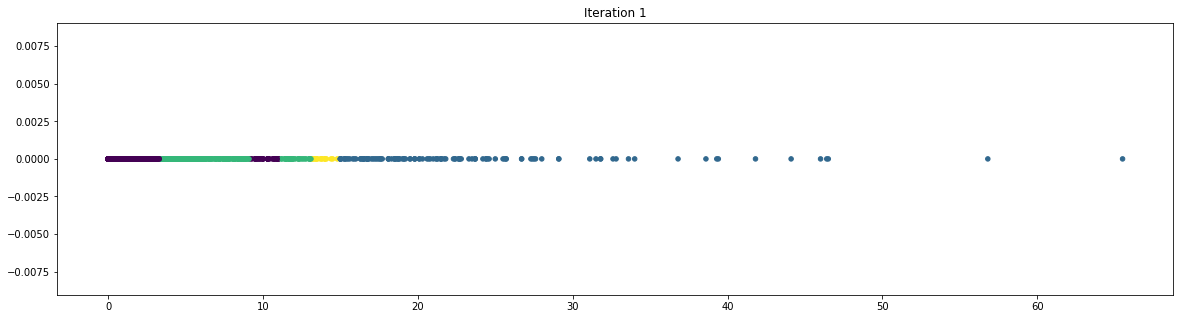

Iteration: 2 -- Parameter Shift: nan -- CPU Time: 205.2415 

     param1    param2  percentage  probZero
0  0.127938  2.879528    0.693607  0.628045
1  4.578911  4.104817    0.093151  0.000000
2  2.498406  1.557567    0.213242  0.000000
3       NaN       NaN    0.000000  0.000000


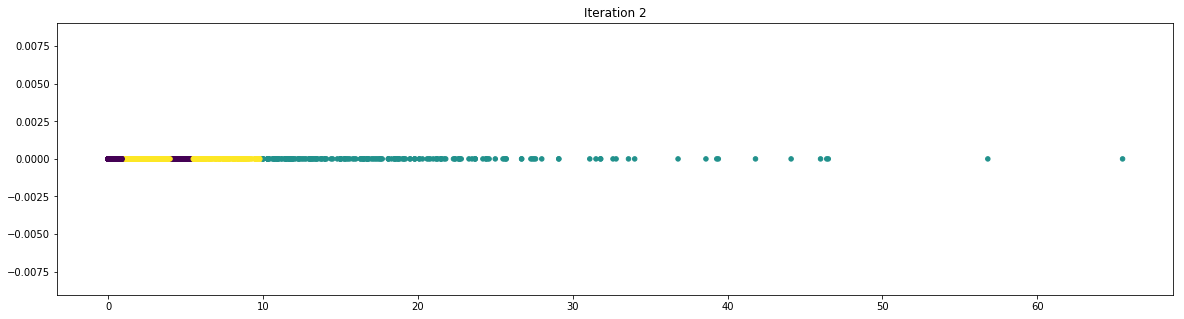

In [22]:
# Two hidden states. 
epsilon= 0.1
numStates= 4
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStatesTest, fittedParametersTest = EMalgorithm(precipitationWindowTime,epsilon, initialParameters , numStates , probType )

Initial parameters are: 
    param1  param2  percentage  probZero
0     7.0     9.4         0.9       1.0
1     5.6     9.0         0.1       1.0 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Iteration: 1 -- Parameter Shift: 258.2654 -- CPU Time: 658.1676 

       param1     param2  percentage  probZero
0    0.179550  12.105304    0.980075  0.486404
1  263.605581   0.038059    0.019925  0.000000


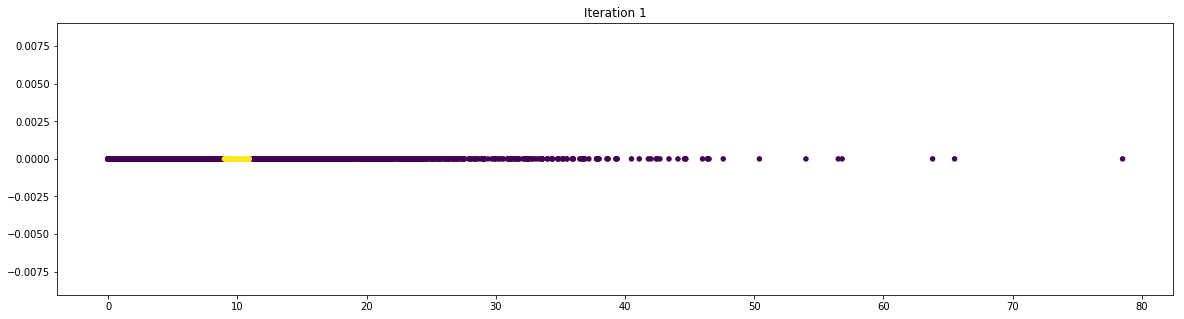

Iteration: 2 -- Parameter Shift: 241.7627 -- CPU Time: 1366.9503 

      param1     param2  percentage  probZero
0   0.134190  13.826251    0.928767  0.513274
1  21.849308   0.389953    0.071233  0.000000


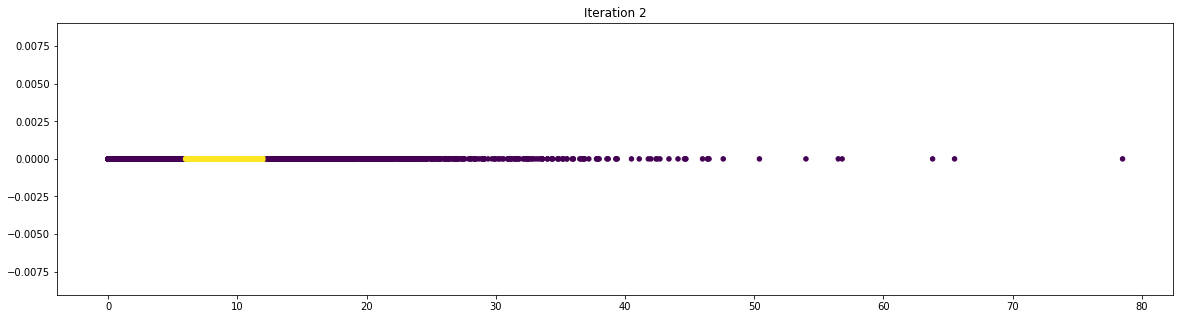

Iteration: 3 -- Parameter Shift: 22.8561 -- CPU Time: 2064.6714 

     param1     param2  percentage  probZero
0  0.027738  13.438028    0.591158  0.806404
1  0.588449   8.769345    0.408842  0.000000


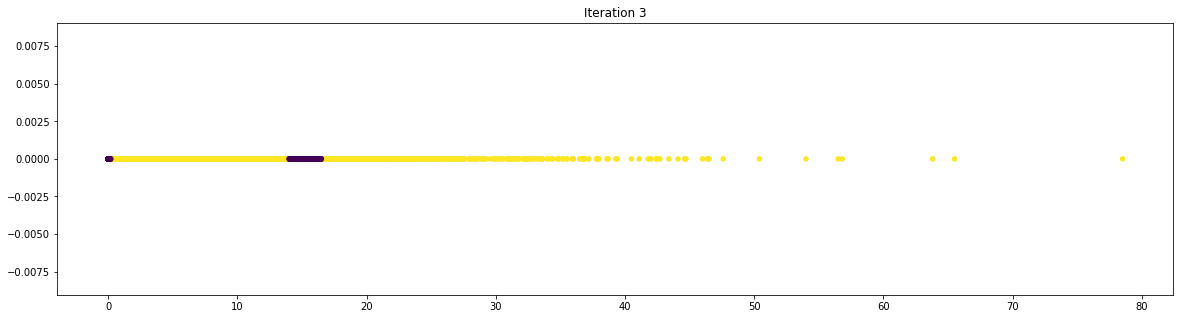

Iteration: 4 -- Parameter Shift: 6.4469 -- CPU Time: 2746.1316 

     param1     param2  percentage  probZero
0  0.165872  11.683703    0.960149  0.496498
1  3.548283   3.319123    0.039851  0.000000


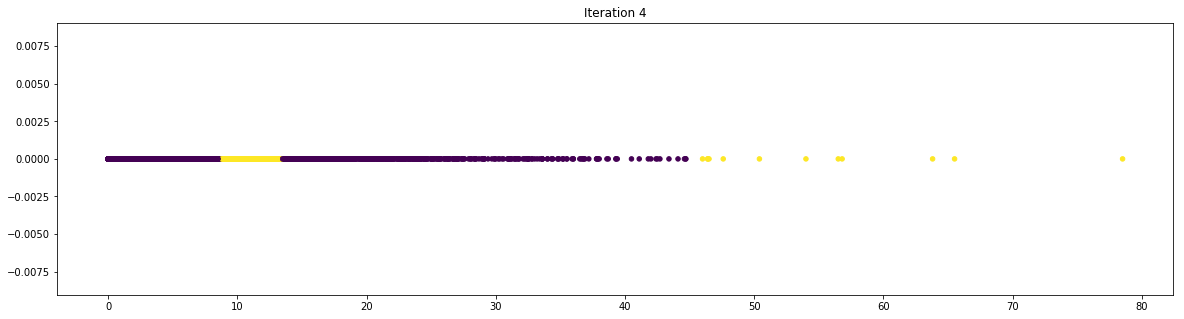

Iteration: 5 -- Parameter Shift: 3.5230 -- CPU Time: 3415.2332 

     param1     param2  percentage  probZero
0  0.114232  13.039286      0.8599  0.554381
1  1.317524   5.684533      0.1401  0.000000


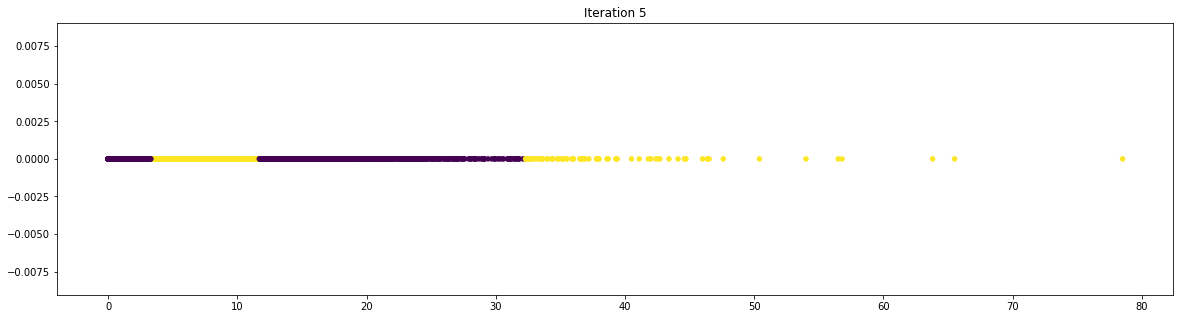

Iteration: 6 -- Parameter Shift: 15.7814 -- CPU Time: 4086.1975 

      param1     param2  percentage  probZero
0   0.123048  14.297003    0.916376  0.520215
1  16.180456   0.530640    0.083624  0.000000


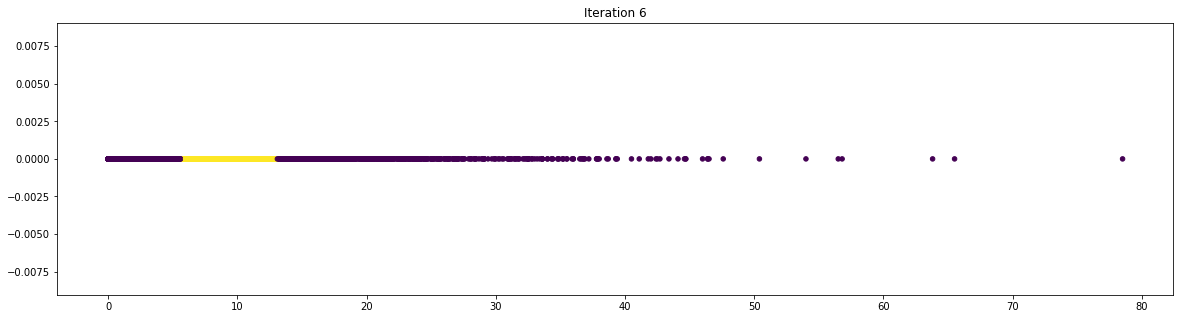

Iteration: 7 -- Parameter Shift: 17.4906 -- CPU Time: 4754.8433 

     param1     param2  percentage  probZero
0  0.024783  11.651889    0.632316  0.753914
1  0.708299   8.245986    0.367684  0.000000


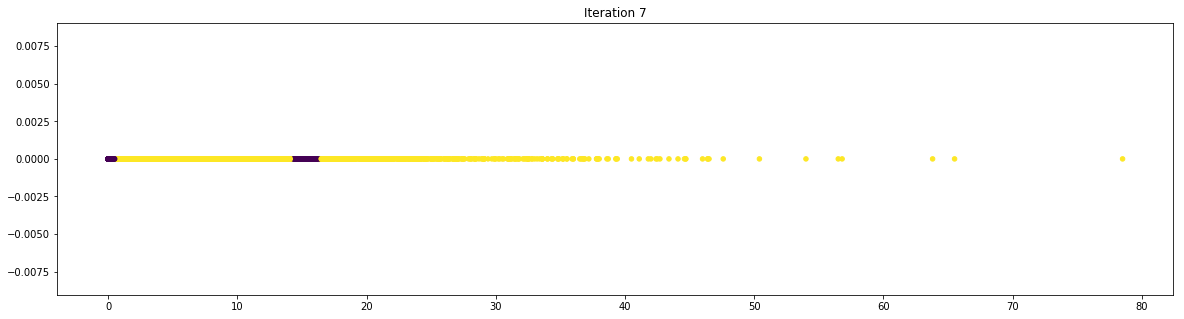

Iteration: 8 -- Parameter Shift: 8.2384 -- CPU Time: 5439.9514 

     param1    param2  percentage  probZero
0  0.249731  4.959355    0.930511  0.512313
1  3.742735  4.528056    0.069489  0.000000


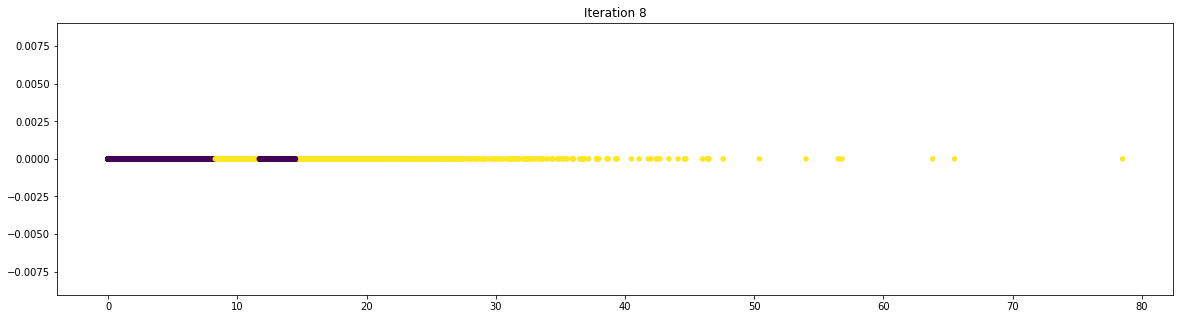

Iteration: 9 -- Parameter Shift: 2.2285 -- CPU Time: 12723.2125 

     param1    param2  percentage  probZero
0  0.291234  2.856044    0.886301  0.537867
1  3.016702  4.644079    0.113699  0.000000


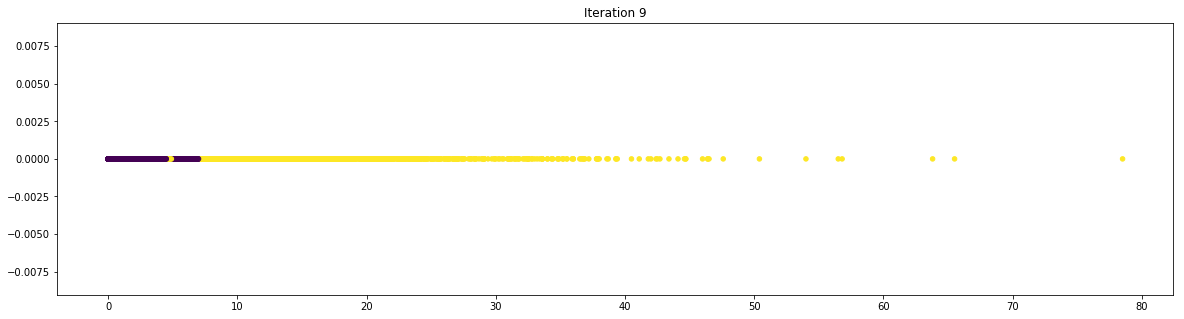

Iteration: 10 -- Parameter Shift: 0.8067 -- CPU Time: 13436.0331 

     param1    param2  percentage  probZero
0  0.304154  2.170264    0.861021  0.553659
1  2.630154  4.819620    0.138979  0.000000


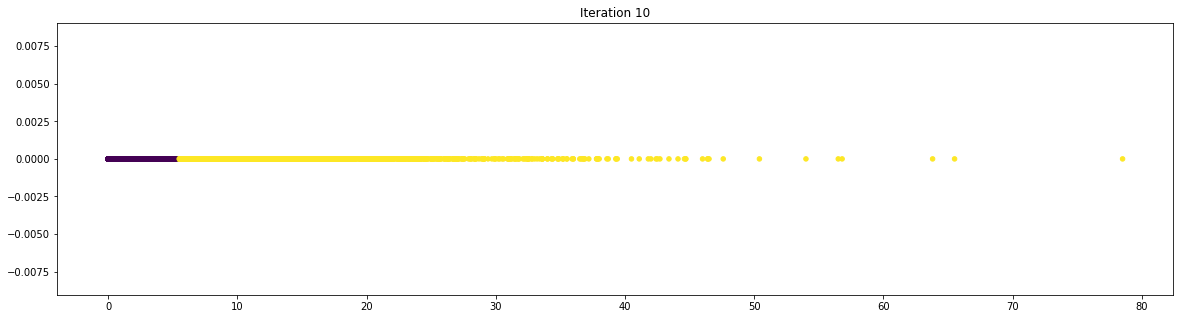

Iteration: 11 -- Parameter Shift: 0.1962 -- CPU Time: 14130.9649 

     param1    param2  percentage  probZero
0  0.304596  2.053692    0.854545  0.557855
1  2.508743  4.920531    0.145455  0.000000


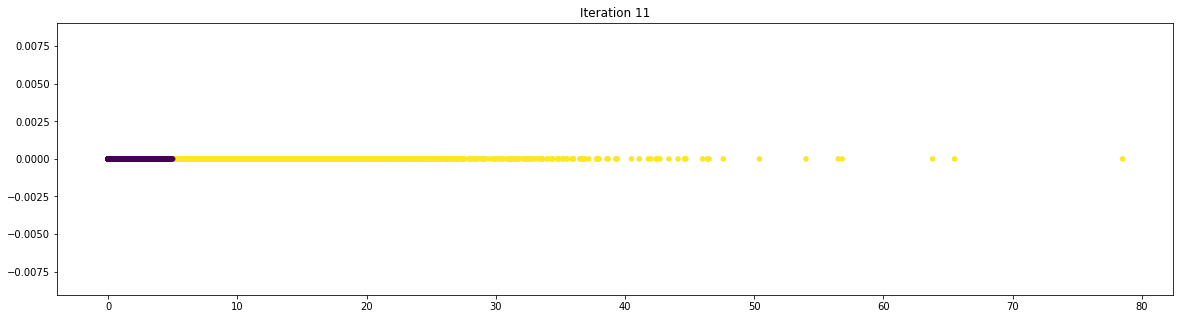

Iteration: 12 -- Parameter Shift: 0.0000 -- CPU Time: 14816.9505 

     param1    param2  percentage  probZero
0  0.304596  2.053692    0.854545  0.557855
1  2.508743  4.920531    0.145455  0.000000


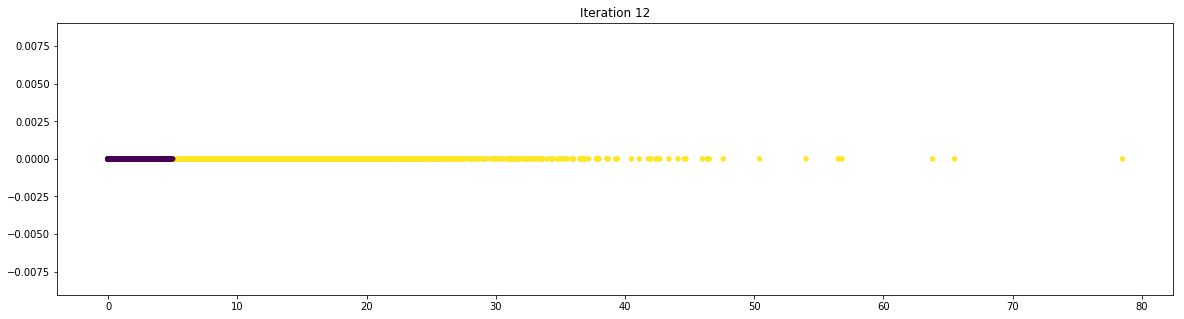

In [23]:
# Two hidden states. 
epsilon= 0.1
numStates= 2
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates2, fittedParameters2 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

In [ ]:
# Three hidden states. 
epsilon= 0.1
numStates= 3
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates3, fittedParameters3 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

Initial parameters are: 
    param1  param2  percentage
0     1.0     3.6    0.090909
1     3.6     9.8    0.363636
2     9.0     8.8    0.409091
3     4.8     4.8    0.136364 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   param1  param2  percentage
0     1.0     3.6    0.090909
1     3.6     9.8    0.363636
2     9.0     8.8    0.409091
3     4.8     4.8    0.136364
Iteration: 1 -- Parameter Shift: 104.3276 -- CPU Time: 709.6594 

       param1    param2  percentage
0    0.304005  2.517270    0.879203
1  101.185860  0.123371    0.030075
2    8.005955  2.856394    0.037360
3   39.563425  0.202549    0.053362


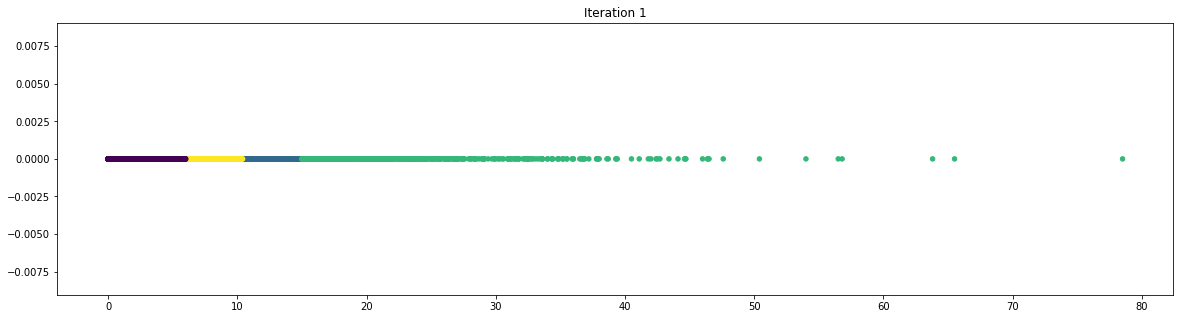

       param1    param2  percentage
0    0.304005  2.517270    0.879203
1  101.185860  0.123371    0.030075
2    8.005955  2.856394    0.037360
3   39.563425  0.202549    0.053362
Iteration: 2 -- Parameter Shift: 115.1319 -- CPU Time: 1434.7040 

     param1     param2  percentage
0  0.205600   3.832113    0.623225
1  0.010421  33.667710    0.032316
2  8.683566   1.370599    0.095766
3  0.149342  18.526744    0.248692


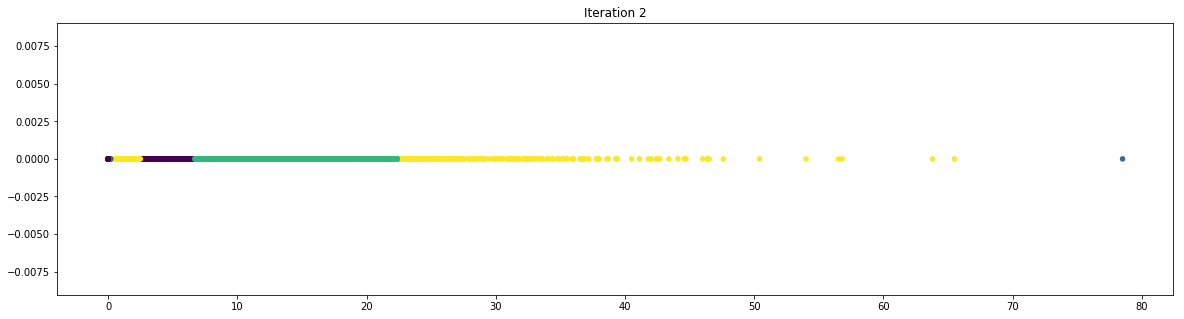

     param1     param2  percentage
0  0.205600   3.832113    0.623225
1  0.010421  33.667710    0.032316
2  8.683566   1.370599    0.095766
3  0.149342  18.526744    0.248692
Iteration: 3 -- Parameter Shift: 116.4971 -- CPU Time: 2163.5499 

       param1    param2  percentage
0    0.157414  3.251964    0.761582
1   32.307989  1.269423    0.003487
2    1.238285  5.425501    0.220299
3  105.367844  0.205816    0.014633


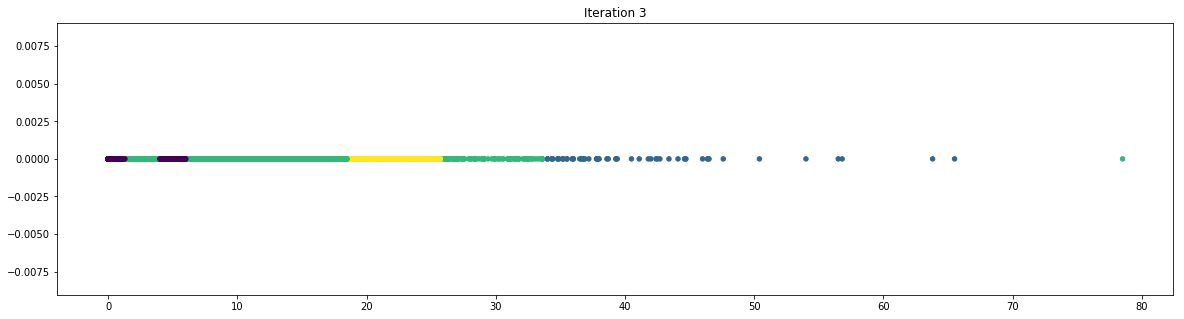

       param1    param2  percentage
0    0.157414  3.251964    0.761582
1   32.307989  1.269423    0.003487
2    1.238285  5.425501    0.220299
3  105.367844  0.205816    0.014633
Iteration: 4 -- Parameter Shift: 111.2558 -- CPU Time: 2888.5662 

     param1     param2  percentage
0  0.116227   3.756031    0.602179
1  0.456425  14.682021    0.130324
2  8.298840   1.178986    0.111270
3  0.108865   6.192753    0.156227


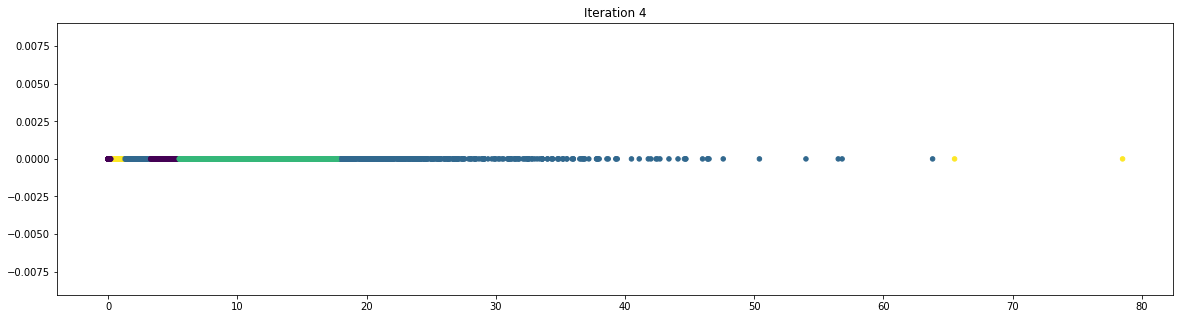

     param1     param2  percentage
0  0.116227   3.756031    0.602179
1  0.456425  14.682021    0.130324
2  8.298840   1.178986    0.111270
3  0.108865   6.192753    0.156227
Iteration: 5 -- Parameter Shift: 1108.0826 -- CPU Time: 3599.6651 

        param1    param2  percentage
0     0.138749  2.965142    0.735679
1   140.202547  0.119724    0.017808
2     0.814474  8.646812    0.233686
3  1099.179061  0.005879    0.012827


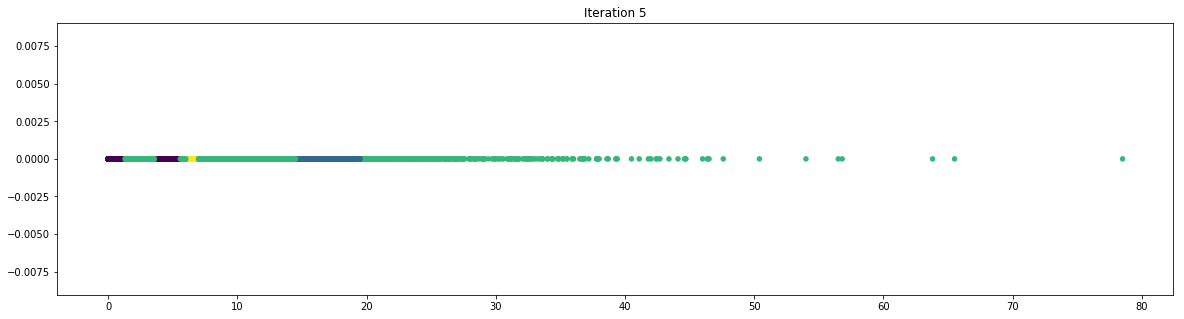

        param1    param2  percentage
0     0.138749  2.965142    0.735679
1   140.202547  0.119724    0.017808
2     0.814474  8.646812    0.233686
3  1099.179061  0.005879    0.012827
Iteration: 6 -- Parameter Shift: nan -- CPU Time: 4313.3285 

     param1    param2  percentage
0  0.204517  4.594460    0.699564
1  0.332770  4.056634    0.215629
2  4.783767  3.406006    0.084807
3       NaN       NaN    0.000000


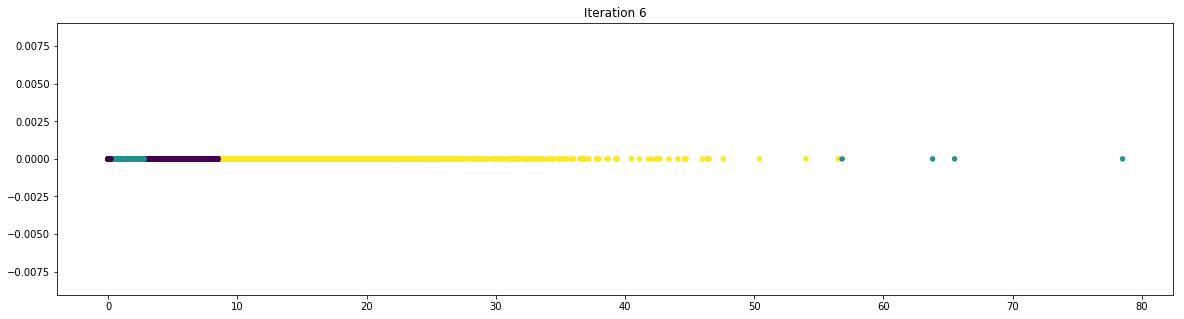

In [271]:
# Four hidden states. 
epsilon= 0.1
numStates= 4
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates4, fittedParameters4 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

Initial parameters are: 
    param1  param2  percentage
0     2.4     9.6        0.32
1     3.2     6.0        0.12
2     4.4     4.8        0.36
3     7.6     6.8        0.20 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   param1  param2  percentage
0     2.4     9.6        0.32
1     3.2     6.0        0.12
2     4.4     4.8        0.36
3     7.6     6.8        0.20
Iteration: 1 -- Parameter Shift: nan -- CPU Time: 703.7408 

      param1    param2  percentage
0   0.180282  5.277616    0.876339
1        NaN       NaN    0.000000
2  21.638183  0.319971    0.080262
3   7.224549  3.000331    0.043400


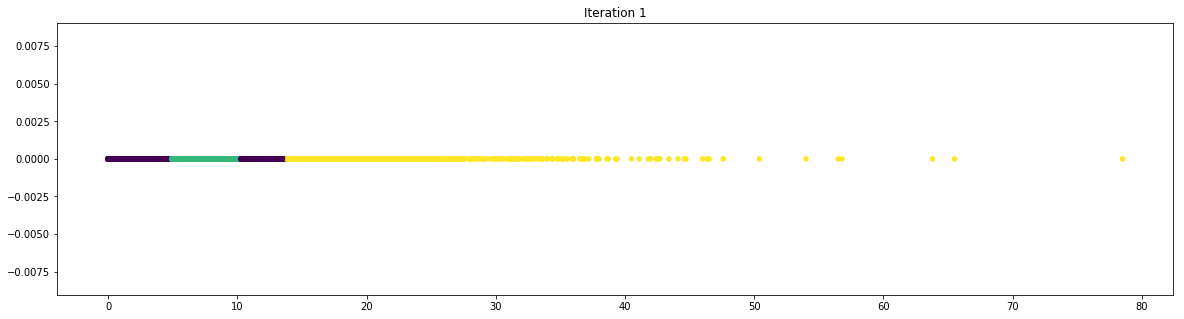

In [272]:
# Four hidden states. 
epsilon= 0.1
numStates= 4
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates4, fittedParameters4 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

Initial parameters are: 
    param1  param2  percentage
0     4.0     3.8    0.045455
1     1.2     6.8    0.272727
2     6.2     7.0    0.090909
3     5.4     1.8    0.363636
4     5.8     5.8    0.227273 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   param1  param2  percentage
0     4.0     3.8    0.045455
1     1.2     6.8    0.272727
2     6.2     7.0    0.090909
3     5.4     1.8    0.363636
4     5.8     5.8    0.227273
Iteration: 1 -- Parameter Shift: 151.7572 -- CPU Time: 696.7313 

       param1    param2  percentage
0    0.288708  0.745878    0.733437
1  150.237934  0.052600    0.027833
2    9.819551  2.583089    0.027397
3    6.277854  0.605458    0.159527
4   31.977713  0.393002    0.051806


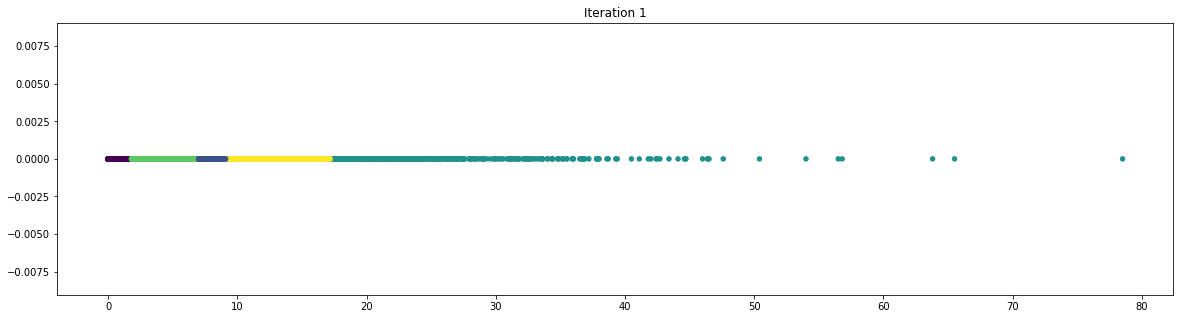

       param1    param2  percentage
0    0.288708  0.745878    0.733437
1  150.237934  0.052600    0.027833
2    9.819551  2.583089    0.027397
3    6.277854  0.605458    0.159527
4   31.977713  0.393002    0.051806
Iteration: 2 -- Parameter Shift: nan -- CPU Time: 1409.9518 

      param1     param2  percentage
0   0.261876   1.512846    0.731507
1        NaN        NaN    0.000000
2  43.269318   0.352604    0.036426
3   4.559238   1.307067    0.153487
4   0.332649  21.806401    0.078580


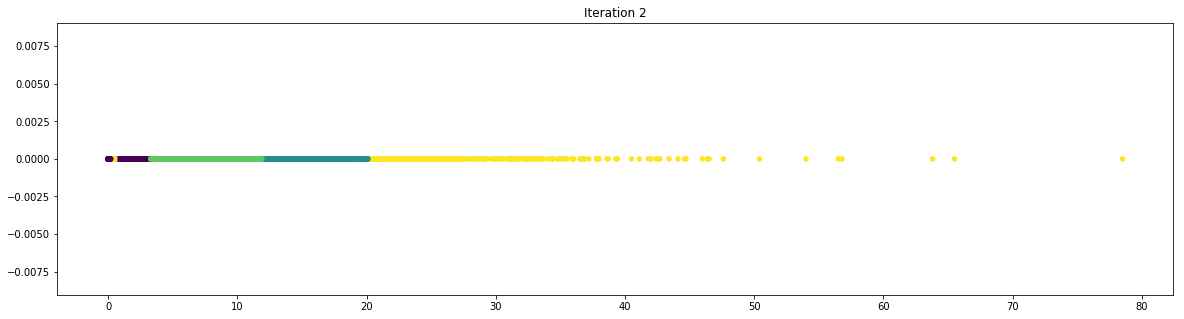

In [273]:
# Five hidden states. 
epsilon= 0.1
numStates= 5
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates5, fittedParameters5 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )

Initial parameters are: 
    param1  param2  percentage
0     4.4     9.2    0.243243
1     9.6     3.2    0.162162
2     8.8     8.6    0.054054
3     6.6     6.2    0.216216
4     4.8     7.4    0.189189
5     8.2     2.0    0.135135 



/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


   param1  param2  percentage
0     4.4     9.2    0.243243
1     9.6     3.2    0.162162
2     8.8     8.6    0.054054
3     6.6     6.2    0.216216
4     4.8     7.4    0.189189
5     8.2     2.0    0.135135
Iteration: 1 -- Parameter Shift: nan -- CPU Time: 693.8906 

       param1    param2  percentage
0    0.086714  9.822076    0.780573
1         NaN       NaN    0.000000
2   10.167653  2.539114    0.025903
3         NaN       NaN    0.000000
4  326.593136  0.031553    0.018182
5    5.317715  0.867965    0.175342


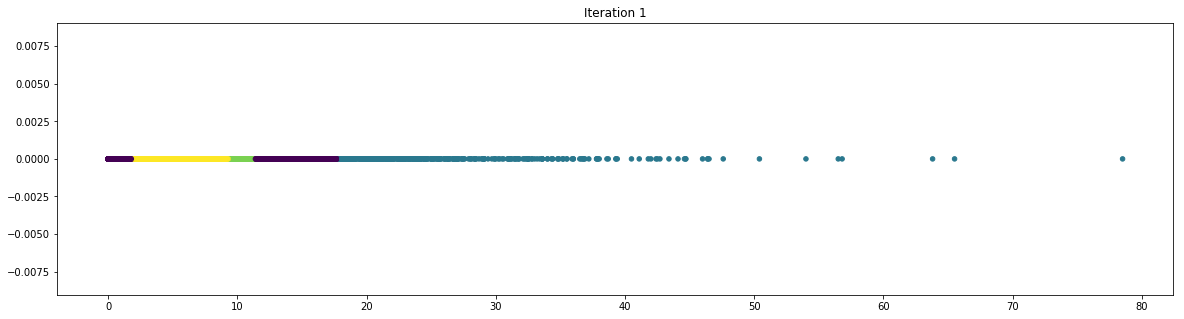

In [274]:
# Six hidden states. 
epsilon= 0.1
numStates= 6
initialParameters = parameterGen(numStates)
print('Initial parameters are: \n',initialParameters,'\n')
probType = 'gamma'

# Apply EM to rainfall historical data.
fittedStates6, fittedParameters6 = EMalgorithm(precipitationAllTime,epsilon, initialParameters , numStates , probType )